In [4]:
# %tensorflow_version 2.x
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
# https://github.com/igul222/PixelVAE/blob/master/tflib/ops/conv2d.py

        if mask_type is not None:
            mask_type, mask_n_channels = mask_type

            mask = np.ones(
                (filter_size, filter_size, input_dim, output_dim), 
                dtype='float32'
            )
            center = filter_size // 2

            # Mask out future locations
            # filter shape is (height, width, input channels, output channels)
            mask[center+1:, :, :, :] = 0.
            mask[center, center+1:, :, :] = 0.

            # Mask out future channels
            for i in xrange(mask_n_channels):
                for j in xrange(mask_n_channels):
                    if (mask_type=='a' and i >= j) or (mask_type=='b' and i > j):
                        mask[
                            center,
                            center,
                            i::mask_n_channels,
                            j::mask_n_channels
                        ] = 0.


NameError: name 'mask' is not defined

In [5]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [6]:
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

height = 32
width = 32
n_channel = 3

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, n_channel)
x_test = x_test.reshape(x_test.shape[0], height, width, n_channel)


In [11]:
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 3

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, 1)
x_test = x_test.reshape(x_test.shape[0], height, width, 1)

x_train = np.concatenate([x_train, x_train, x_train], axis=3)
x_test = np.concatenate([x_test, x_test, x_test], axis=3)

train_filter = np.isin(y_train, list(range(5)))
test_filter = np.isin(y_test, list(range(5)))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

In [12]:
x_train[y_train==0, :,:,0] = x_train[y_train==0, :,:,0] * 0.75
x_train[y_train==0, :,:,1] = x_train[y_train==0, :,:,1] * 0.
x_train[y_train==0, :,:,2] = x_train[y_train==0, :,:,2] * 0.

x_train[y_train==1, :,:,0] = x_train[y_train==1, :,:,0] * 0.
x_train[y_train==1, :,:,1] = x_train[y_train==1, :,:,1] * 0.5
x_train[y_train==1, :,:,2] = x_train[y_train==1, :,:,2] * 0.

x_train[y_train==2, :,:,0] = x_train[y_train==2, :,:,0] * 0.
x_train[y_train==2, :,:,1] = x_train[y_train==2, :,:,1] * 0.
x_train[y_train==2, :,:,2] = x_train[y_train==2, :,:,2] * 0.25

x_train[y_train==3, :,:,0] = x_train[y_train==3, :,:,0] * 0.5
x_train[y_train==3, :,:,1] = x_train[y_train==3, :,:,1] * 0.5
x_train[y_train==3, :,:,2] = x_train[y_train==3, :,:,2] * 0.

x_train[y_train==4, :,:,0] = x_train[y_train==4, :,:,0] * 0.5
x_train[y_train==4, :,:,1] = x_train[y_train==4, :,:,1] * 0.
x_train[y_train==4, :,:,2] = x_train[y_train==4, :,:,2] * 0.5

x_train[y_train==5, :,:,0] = x_train[y_train==5, :,:,0] * 0.
x_train[y_train==5, :,:,1] = x_train[y_train==5, :,:,1] * 0.5
x_train[y_train==5, :,:,2] = x_train[y_train==5, :,:,2] * 0.5

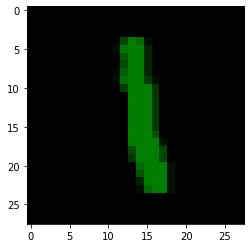

In [9]:
plt.imshow(x_train[4])

In [10]:
height = 10
width = 10
n_channel = 3

x_train = np.zeros((10000,height,width, n_channel))+ 0.2*np.random.rand(10000,height,width, n_channel)
x_train[:5000,:5,:,0] = 1.
x_train[:5000,5:,:,0] = 0.5
x_train[:5000,5:,:,1] = 0.5
x_train[5000:,:,:5,1] = 1.
x_train[5000:,:,5:,2] = 1.
x_train.shape

(10000, 10, 10, 3)

In [13]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [14]:
# Quantise the input data in q levels
q_levels = 256
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

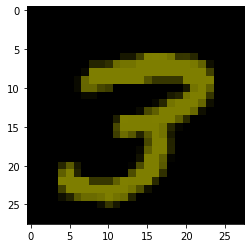

In [15]:
x_train_quantised.shape
plt.imshow(x_train[100])

In [16]:
# Creating input stream using tf.data API
batch_size = 256
train_buf = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

In [17]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[self.kernel_size // 2, self.kernel_size // 2 + 1:, :, :] = 0.
        mask[self.kernel_size // 2 + 1:, :, :, :] = 0.

        if self.mask_type =='A':
            mask[self.kernel_size // 2, self.kernel_size // 2, :, :int(self.filters/3)] = 0.
            mask[self.kernel_size // 2, self.kernel_size // 2, 1:, int(self.filters/3):2*int(self.filters/3)] = 0.
            mask[self.kernel_size // 2, self.kernel_size // 2, 2:, 2*int(self.filters/3):] = 0.
        else:
            mask[self.kernel_size // 2, self.kernel_size // 2, int(int(input_shape[-1])/3):, :int(self.filters/3)] = 0.
            mask[self.kernel_size // 2, self.kernel_size // 2, 2*int(int(input_shape[-1])/3):, int(self.filters/3):2*int(self.filters/3)] = 0.

        # def bmask(i_out, i_in):
        #     cout_idx = np.expand_dims(np.arange(self.filters) % 3 == i_out, 0)
        #     cin_idx = np.expand_dims(np.arange(int(input_shape[-1])) % 3 == i_in, 1)
        #     a1, a2 = np.broadcast_arrays(cout_idx, cin_idx)
        #     return a1 * a2


        # for j in range(3):
        #     mask[self.kernel_size // 2, self.kernel_size // 2, bmask(j, j)] = 0. if self.mask_type == 'A' else 1.

        # mask[self.kernel_size // 2, self.kernel_size // 2, bmask(0, 1)] = 0.
        # mask[self.kernel_size // 2, self.kernel_size // 2, bmask(0, 2)] = 0.
        # mask[self.kernel_size // 2, self.kernel_size // 2, bmask(1, 2)] = 0.

        self.mask = tf.constant(mask, dtype=tf.float32, name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

In [0]:
input_shape = (10,10,3)
mask_type = 'A'
kernel_size = 5
filters = 9
kernel = np.ones((kernel_size, kernel_size, 3, filters))
mask = np.ones(kernel.shape, dtype=np.float32)
mask[:,:,0,0]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [0]:
mask[kernel_size // 2, kernel_size // 2 + 1:, :, :] = 0.
mask[kernel_size // 2 + 1:, :, :, :] = 0.
mask[:,:,0,0]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
def bmask(i_out, i_in):
    cout_idx = np.expand_dims(np.arange(filters) % 3 == i_out, 0)
    cin_idx = np.expand_dims(np.arange(int(input_shape[-1])) % 3 == i_in, 1)
    a1, a2 = np.broadcast_arrays(cout_idx, cin_idx)
    return a1 * a2

for j in range(3):
    mask[kernel_size // 2, kernel_size // 2, bmask(j, j)] = 0. if mask_type == 'A' else 1.

mask[:,:,0,0]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
mask[kernel_size // 2, kernel_size // 2, bmask(0, 1)] = 0.
mask[kernel_size // 2, kernel_size // 2, bmask(0, 2)] = 0.
mask[kernel_size // 2, kernel_size // 2, bmask(1, 2)] = 0.
mask[:,:,0,0]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)



---



In [0]:
input_shape = (10,10,3)
mask_type = 'A'
kernel_size = 5
filters = 9
kernel = np.ones((kernel_size, kernel_size, 3, filters))
mask = np.ones(kernel.shape, dtype=np.float32)
mask[:,:,0,0]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [0]:
mask[kernel_size // 2, kernel_size // 2 + 1:, :, :] = 0.
mask[kernel_size // 2 + 1:, :, :, :] = 0.
mask[:,:,0,0]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
mask_type ='b'
in_channel = 3
if mask_type =='A':
    mask[kernel_size // 2, kernel_size // 2, :, :int(filters/3)] = 0.
    mask[kernel_size // 2, kernel_size // 2, 1:, int(filters/3):2*int(filters/3)] = 0.
    mask[kernel_size // 2, kernel_size // 2, 2:, 2*int(filters/3):] = 0.
else:
    mask[kernel_size // 2, kernel_size // 2, int(in_channel/3):, :int(filters/3)] = 0.
    mask[kernel_size // 2, kernel_size // 2, 2*int(in_channel/3):, int(filters/3):2*int(filters/3)] = 0.

mask[:,:,0,0]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

In [19]:
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In [20]:
# Prepare optimizer and loss function
lr_decay = 0.9999
learning_rate = 5e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [21]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In [23]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [24]:

with tf.device("/job:localhost/replica:0/task:0/device:GPU:1"):
    # Training loop
    n_epochs = 50
    n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
    for epoch in range(n_epochs):
        start_epoch = time.time()
        for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
            start = time.time()
            optimizer.lr = optimizer.lr * lr_decay
            loss = train_step(batch_x, batch_y)
            iter_time = time.time() - start
            if i_iter % 100 == 0:
                print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                       i_iter, n_iter,
                                                                                       iter_time,
                                                                                       loss))
        epoch_time = time.time() - start_epoch
        print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                             epoch_time,
                                                             epoch_time * (n_epochs - epoch)))


EPOCH   0: ITER    0/ 120 TIME: 14.32 LOSS: 5.5452


KeyboardInterrupt: 

In [0]:
A = np.zeros((1,10,10,3))
B = pixelcnn(A)
B = tf.reshape(B, [-1, height, width, q_levels, n_channel])
B = tf.transpose(B, perm=[0, 1, 2, 4, 3])
next_sample = tf.random.categorical(B[0,0,0,0,:][None,:], 1)
next_sample


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[3]])>

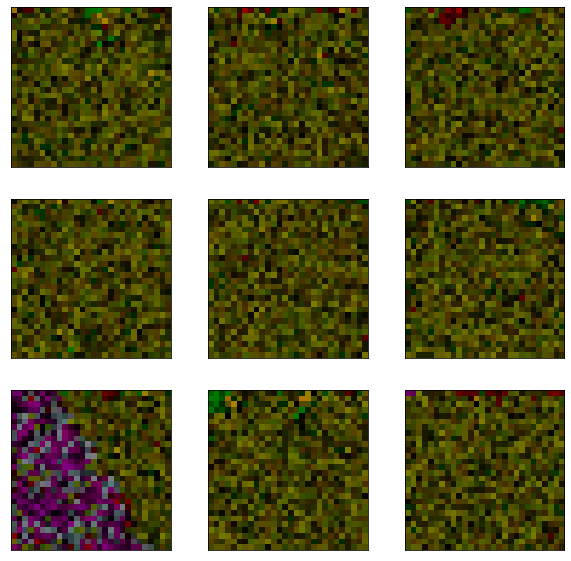

In [0]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((10, height,width,n_channel)) + + 0.5*np.random.rand(10,height,width, n_channel)

for i in range(height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

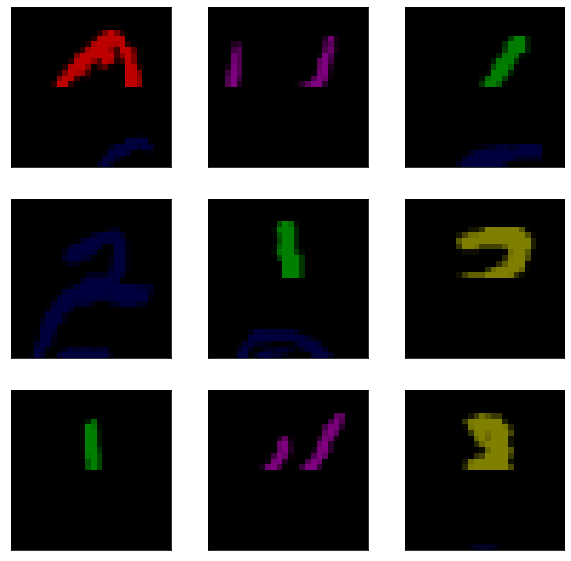

In [0]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
occlude_start_row = 14
num_generated_images = 1
samples = np.copy(x_train_quantised[:10, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

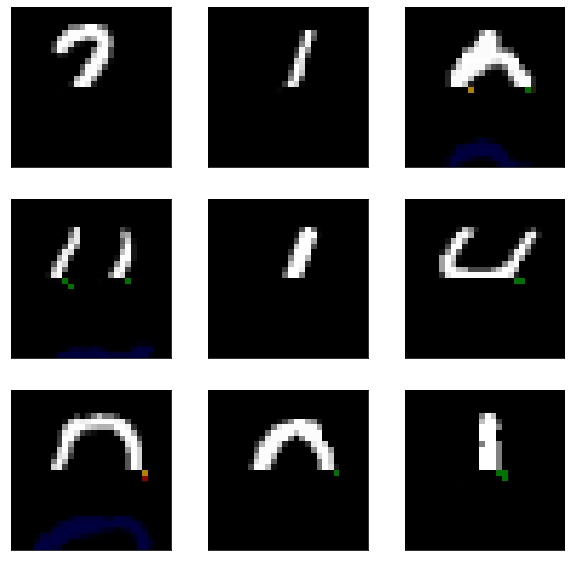

In [0]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        for k in range(n_channel):
            logits = pixelcnn(samples)
            logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
            logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
            next_sample = tf.random.categorical(logits[:, i, j, k, :], 1)
            samples[:, i, j, k] = (next_sample.numpy() / (q_levels - 1))[:, 0]
            

fig = plt.figure(figsize=(10, 10))
for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(samples[i, :, :, :])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()